In [1]:
! pip install numpy matplotlib opencv-python scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 792.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.2 MB/s eta 0:00:00


In [2]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [3]:
# Load LFW dataset (only those with at least 20 images)
lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5)
print("Number of classes:", len(lfw.target_names))
print("Class names:", lfw.target_names)
print("Data shape:", lfw.images.shape)
print("Number of samples per class:", np.bincount(lfw.target))

Number of classes: 62
Class names: ['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Williams' 'Silvio

In [4]:
# Select target person for binary classification
person_name = 'Juan Carlos Ferrero'  # Target person
target_idx = np.where(lfw.target_names == person_name)[0][0]
print(f"Target person: {person_name}, index: {target_idx}")

Target person: Juan Carlos Ferrero, index: 34


In [5]:
# Create binary labels (1 for target person, 0 for others)
y_binary = (lfw.target == target_idx).astype(np.int32)
print(f"Number of positive samples: {np.sum(y_binary)}")
print(f"Number of negative samples: {len(y_binary) - np.sum(y_binary)}")

Number of positive samples: 28
Number of negative samples: 2995


In [6]:
# Preprocess the data
X = lfw.images

In [7]:
# Normalize pixel values to [0, 1]
X = X / 255.0

In [8]:
# Reshape for CNN input (height, width, channels)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (2418, 62, 47, 1)
Test set shape: (605, 62, 47, 1)


In [10]:
# Build CNN model with regularization
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    layers.BatchNormalization(),  # Normalize activations
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Regularization

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Higher dropout for dense layers

    # Output layer
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 45, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 487,553 (1.86 MB)

 Trainable params: 486,849 (1.86 MB)

 Non-trainable params: 704 (2.75 KB)

In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1
)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5852 - loss: 0.8705 - precision: 0.0084 - recall: 0.4489 - val_accuracy: 0.9901 - val_loss: 0.1441 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8578 - loss: 0.3979 - precision: 0.0408 - recall: 0.4246 - val_accuracy: 0.9901 - val_loss: 0.0637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9595 - loss: 0.1866 - precision: 0.0208 - recall: 0.0850 - val_accuracy: 0.9901 - val_loss: 0.1747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9776 - loss: 0.1145 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9901 - val_loss: 0.4047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9911 - loss: 0.0643 - precision: 0.0000e+00 - recall: 0.000

In [13]:
# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")

Test Accuracy: 96.20%
Test Precision: 0.00%
Test Recall: 0.00%


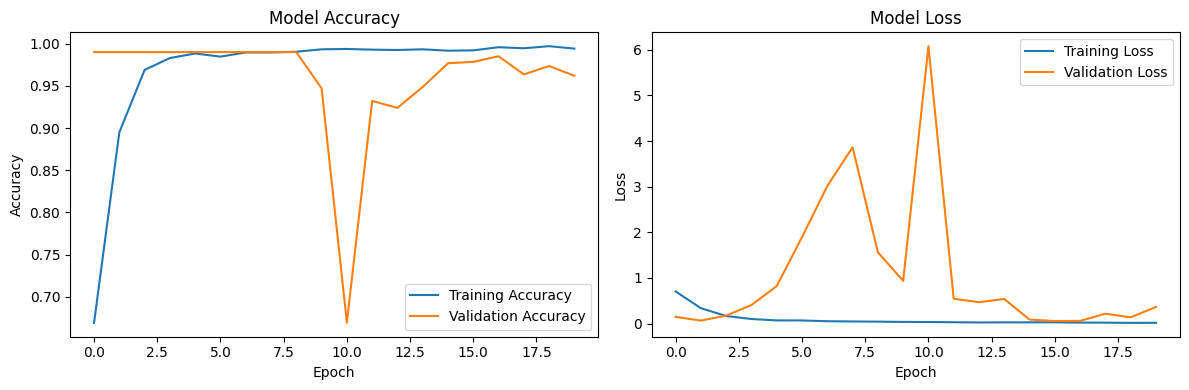

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Make predictions on test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [16]:
# Calculate and display additional metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Other', person_name]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
                     precision    recall  f1-score   support

              Other       0.99      0.97      0.98       599
Juan Carlos Ferrero       0.00      0.00      0.00         6

           accuracy                           0.96       605
          macro avg       0.49      0.49      0.49       605
       weighted avg       0.98      0.96      0.97       605


Confusion Matrix:
[[582  17]
 [  6   0]]


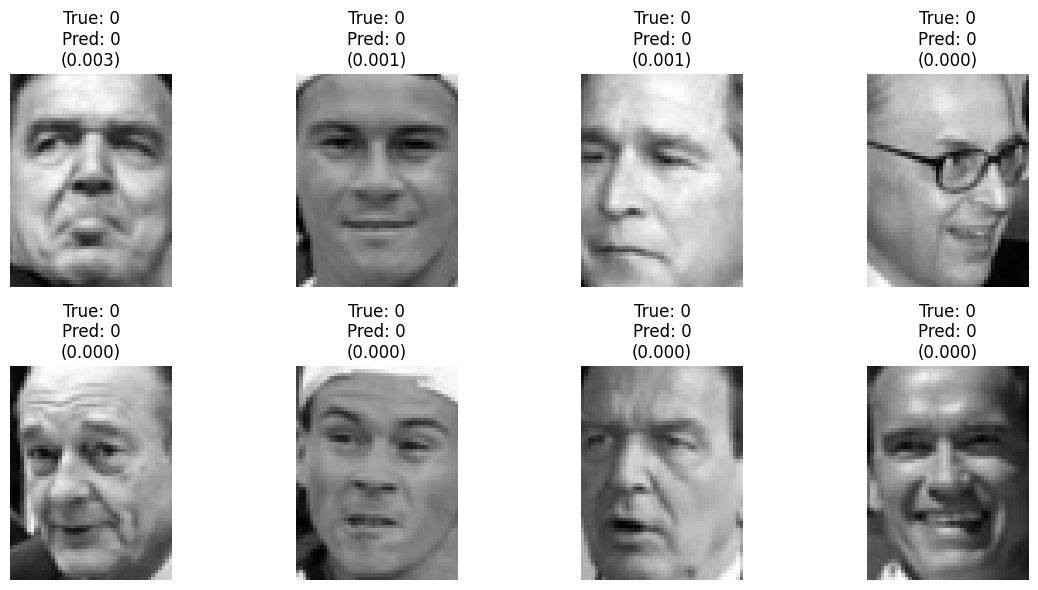

In [17]:
# Display sample predictions with confidence scores
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    # Select a random test image
    idx = np.random.randint(0, X_test.shape[0])
    sample_image = X_test[idx]
    true_label = y_test[idx]

    # Predict
    prediction_prob = model.predict(sample_image.reshape(1, X.shape[1], X.shape[2], 1), verbose=0)[0][0]
    predicted_label = 1 if prediction_prob >= 0.5 else 0

    # Display
    axes[i].imshow(sample_image.reshape(X.shape[1], X.shape[2]), cmap='gray')
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}\n({prediction_prob:.3f})")
    axes[i].axis('off')

    # Color code based on correctness
    if true_label == predicted_label:
        axes[i].set_frame_on(True)
        axes[i].patch.set_edgecolor('green')
        axes[i].patch.set_linewidth(3)
    else:
        axes[i].set_frame_on(True)
        axes[i].patch.set_edgecolor('red')
        axes[i].patch.set_linewidth(3)

plt.tight_layout()
plt.show()